# Анализ убытков приложения ProcrastinatePRO+

Я являюсь маркетинговым аналитиком приложения Procrastinate Pro+. Несколько прошлых месяцев  бизнес постоянно нес убытки - в привлечение пользователей была вложена куча денег, а толку никакого.

У нас в распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. 

У нас есть три датасета:

1. **visits_log_short (лог сервера с информацией о посещениях сайта)**:
 * User Id — уникальный идентификатор пользователя;
 * Device — категория устройства пользователя;
 * Session start — дата и время начала сессии;
 * Session End — дата и время окончания сессии;
 * Channel — идентификатор рекламного источника, из которого пришел пользователь;
 * Region - страна пользователя.
 
2. **orders_log_short (информация о заказах)**:
 * User Id — уникальный id пользователя, который сделал заказ;
 * Event Dt — дата и время покупки;
 * Revenue — выручка.
 
3. **costs_short (информация о затратах на маркетинг)**:

 * Channel — идентификатор рекламного источника;
 * Dt — дата;
 * Costs — затраты на этот рекламный источник в этот день.

# Содержание:

1. [Загрузка данных](#start)
2. [Подготовка данных](#preparing)
3. [Задаем функции для расчета и анализа LTV, ROI, удержания и конверсии](#function)
4. [Исследовательский анализ данных](#main)
* [Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?](#country)
* [Какими устройствами пользуются наши клиенты? С каких устройств чаще всего заходят платящие пользователи?](#devices)
* [По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?](#channels)
5. [Маркетинг](#marketing)
6. [Выявление окупаемости рекламы для привлечения пользователей](#payback)
* [Анализ общей окупаемости рекламы](#common_payback)
* [Анализ окупаемости рекламы с разбивкой по устройствам](#devices_payback)
* [Анализ окупаемости рекламы с разбивкой по странам](#country_payback)
* [Анализ окупаемости рекламы с разбивкой по рекламным каналам](#channels_payback)
* [Чем могут быть вызваны проблемы окупаемости?](#payback_problems)
    * [Анализ  конверсии и удержания с разбивкой по странам](#conversion_retention_country)
    * [Анализ  конверсии и удержания с разбивкой по рекламным каналам](#conversion_retention_channels)
    * [Анализ  конверсии и удержания с разбивкой по устройствам](#conversion_retention_devices)
7.[Выводы и рекомендации](#conclusion)

<a id="start"></a>
# Загрузка данныx 

Перед началом нашей работы с данными, импортируем нужные для работы библиотеки:
   * pandas
   * numpy
   * datetime
   * matplotlib

In [1]:
# импортируем нужные библиотеки
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
pd.set_option('display.float_format', '{:.2f}'.format)

Данные для анализа нам предоставили в трех csv-файлах, который мы сохраним в переменные:
* `visits` - информация о посещениях сайта;
* `orders` - информация о заказах;
* `costs` - информация о расходах на рекламу.

In [2]:
# загружаем данные
try:
    visits = (
    pd.read_csv('C:/Users/vaska/Desktop/new_rules/projects/datasets/visits_info_short.csv')
    )
except:
    visits = pd.read_csv('/datasets/visits_info_short.csv')
try:
    orders = (
    pd.read_csv('C:/Users/vaska/Desktop/new_rules/projects/datasets/orders_info_short.csv')
    )
except:
    orders = pd.read_csv('/datasets/orders_info_short.csv')
try:
    costs = (
    pd.read_csv('C:/Users/vaska/Desktop/new_rules/projects/datasets/costs_info_short.csv')
    )
except:
    costs = pd.read_csv('/datasets/costs_info_short.csv')
    
events = None

<a id="preparing"></a>
# Подготовка данных

Пишем функцию `function`, которая будет выводить:
 * первые 5 строк таблицы;
 * размер таблицы;
 * информацию о таблице;
 * количество прямых дубликатов;
 * количество пропусков в процентном соотношении.

Так же поменям верхний регист на нижний и заменим пробелы на нижний слеш в названиях столбцов, где это необходимо.

In [3]:
# создаем функцию function  
def function(df):
    print ('------------- Краткая информация ------------')
    df.columns = map(str.lower, df.columns)
    df.columns = df.columns.str.replace(' ','_')
    display(df.head())
    print('Размер таблицы:', df.shape)
    df.info()
    print('Количество дубликатов:', df.duplicated().sum())
    print()
    print ('-------------  Количество пропусков ------------')
    display(pd.DataFrame(round((df.isna().mean()*100),2)).style.background_gradient('coolwarm'))

Вызовем наши таблицы.

In [4]:
# вызов таблицы
function(visits)

------------- Краткая информация ------------


,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


Размер таблицы: (309901, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        309901 non-null  int64 
 1   region         309901 non-null  object
 2   device         309901 non-null  object
 3   channel        309901 non-null  object
 4   session_start  309901 non-null  object
 5   session_end    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
Количество дубликатов: 0

-------------  Количество пропусков ------------


,0
user_id,0.000000
region,0.000000
device,0.000000
channel,0.000000
session_start,0.000000
session_end,0.000000


In [5]:
# вызов таблицы
function(orders)

------------- Краткая информация ------------


,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


Размер таблицы: (40212, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   40212 non-null  int64  
 1   event_dt  40212 non-null  object 
 2   revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
Количество дубликатов: 0

-------------  Количество пропусков ------------


,0
user_id,0.000000
event_dt,0.000000
revenue,0.000000


In [6]:
# вызов таблицы
function(costs)

------------- Краткая информация ------------


,dt,channel,costs
0,2019-05-01,FaceBoom,113.30
1,2019-05-02,FaceBoom,78.10
2,2019-05-03,FaceBoom,85.80
3,2019-05-04,FaceBoom,136.40
4,2019-05-05,FaceBoom,122.10


Размер таблицы: (1800, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
Количество дубликатов: 0

-------------  Количество пропусков ------------


,0
dt,0.000000
channel,0.000000
costs,0.000000


Как видим, ряд столбцов в наших датсетах нужно перевести в формат `datetime`.

In [7]:
# приводим к нужному формату наши столбцы
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

**ВЫВОДЫ**

В ходе подготовки данных мы:
   * поменяли верхний регистр на нижний;
   * заменили пробелы на нижний слеш в названиях столбцов, где это необходимо;
   * ряд столбцов в наших датсетах перевели в формат `datetime`.
 
Дубликатов и пропусков в датасетах нет. Данные успешно проверены и готовы к дальнейшему анализу.

<a id="function"></a>
# Задаем функции для расчета и анализа LTV, ROI, удержания и конверсии

Пишем функции для расчета и анализа LTV, ROI, удержания и конверсии.

In [8]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [9]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 
# а также функции для визуализации этих метрик — filter_data(), plot_retention(), 
# plot_conversion() и plot_ltv_roi().
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')
 # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [10]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [11]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

<a id="main"></a>
# Исследовательский анализ данных

Перед началом анализа нам нужно создать пользовательские профили, а затем определить минимальную и максимальную даты привлечения пользователей.

Пишем функцию для создания пользовательских профилей.

In [12]:
# функция для создания пользовательских профилей
def get_profiles(sessions, orders, events, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

Сохраняем наши данные в переменную `profiles`.

In [13]:
# получаем профили пользователей
profiles = get_profiles(visits, orders, events, costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.09
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.11
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.00
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.99
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.23


Теперь определим минимальную и максимальную дату привлечения пользователей.

In [14]:
# определяем минимальную и максимальную дату нашего анализа
print('Минимальная дата привлечения пользователей:', profiles['dt'].min())
print('Максимальная дата привлечения пользователей:', profiles['dt'].max())

Минимальная дата привлечения пользователей: 2019-05-01
Максимальная дата привлечения пользователей: 2019-10-27


Как видим, первая дата привлечения пользователя 1 мая 2019, а окончание 27 октября, что соответствовало нашим ожиданиям.

<a id="country"></a>
## Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?

Для того чтобы разобраться в причинах финансовых неудач компании пройдём по всем доступным характеристикам пользователей — стране, источнику и устройству первого посещения.
Начнём с разбивки по странам: изучим, сколько пользователей пользуются нашим приложение и долю платящих из них.

In [15]:
# группируем данные по региону
display(
    profiles.groupby('region').
    agg({'user_id': 'nunique','payer': 'mean'})
    .sort_values(by = 'payer', ascending = False)
    .reset_index()
)

,region,user_id,payer
0,United States,100002,0.07
1,Germany,14981,0.04
2,UK,17575,0.04
3,France,17450,0.04


Наибольшее количество пользователей у нас проживает:
 * в США - 66%;
 * затем практически вровень идут Великобритания и Франция - по 11% на каждую страну;
 * наименьшее количество пользователей приходит из Германии - 9%.
 
Количество платящих пользователей по странам немного отличается: 
 * лидирующее место все так же за США - 6%;
 * делее идет Германия - 4%;
 * затем следует Великобритания и Франция - 3%. 

<a id="devices"></a>
##  Какими устройствами пользуются наши клиенты? С каких устройств чаще всего заходят платящие пользователи? 

После изучения посетителей по странам, изучим, какими девайсами они предпочитают пользоваться.

In [16]:
# группируем данные по устройствам
divices = (
    profiles.groupby('device').
    agg({'user_id': 'nunique','payer': 'mean'})
    .sort_values(by = 'payer', ascending = False)
    .reset_index()
)
# находим долю от общего количества устройств
divices['total'] =  divices['user_id'] / sum(divices['user_id'])
divices

,device,user_id,payer,total
0,Mac,30042,0.06,0.20
1,iPhone,54479,0.06,0.36
2,Android,35032,0.06,0.23
3,PC,30455,0.05,0.20


Больше всего наши клиенты пользуются:
 * iPhone - 36%;
 * Android - 23%;
 * персональными компьютерами разных операционных систем - около 20%.

<a id="channels"></a>
## По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей? 

Теперь посмотрим на наши рекламные источники привлечения.

In [17]:
# группируем данные по рекламным источникам привлечения
channels = (
    profiles.groupby('channel').
    agg({'user_id': 'nunique','payer': 'mean'})
    .sort_values(by = 'user_id', ascending = False)
    .reset_index()
)
# находим долю от общего количества устройств
channels['total'] =  channels['user_id'] / sum(channels['user_id'])
channels

,channel,user_id,payer,total
0,organic,56439,0.02,0.38
1,FaceBoom,29144,0.12,0.19
2,TipTop,19561,0.10,0.13
3,OppleCreativeMedia,8605,0.03,0.06
4,LeapBob,8553,0.03,0.06
5,WahooNetBanner,8553,0.05,0.06
6,RocketSuperAds,4448,0.08,0.03
7,MediaTornado,4364,0.04,0.03
8,YRabbit,4312,0.04,0.03
9,AdNonSense,3880,0.11,0.03


У нас довольно много каналов привлечение - целых 11. 

При том надо отметить, что больше всего посетителей приходит:
* органически - 38%, но лишь 2% готовы платить;
* затем идет `FaceBoom`(19%), который является лидером по платным пользователям - 12%;
* канал `TipTop`(13%), приносящий нам 10% покупателей.

Помимо FaceBoom, каналы `AdNonSense`(11%) и `lambdaMediaAds`(10%), так же являютя лидерами по привлечению платящих пользователей.

**ВЫВОДЫ**

* первая дата привлечения пользователя 1 мая 2019, а окончание 27 октября, что соответствовало нашим ожиданиям;
* больше всего приходит пользователей из США, и они лучше других конвертируется;
* большая часть пользователей заходит с мобильных устройств;
* наибольшую конверсию имеют пользователи Apple.

<a id="marketing"></a>
# Маркетинг

Посчитаем общую сумму расходов на маркетинг. Выясним, как затраты распределены по источникам. Визуализируем изменения метрик во времени. Узнаем, сколько в среднем стоило привлечение одного покупателя из каждого источника.

Общая сумма расходов на маркетинг -  105497.29999999999


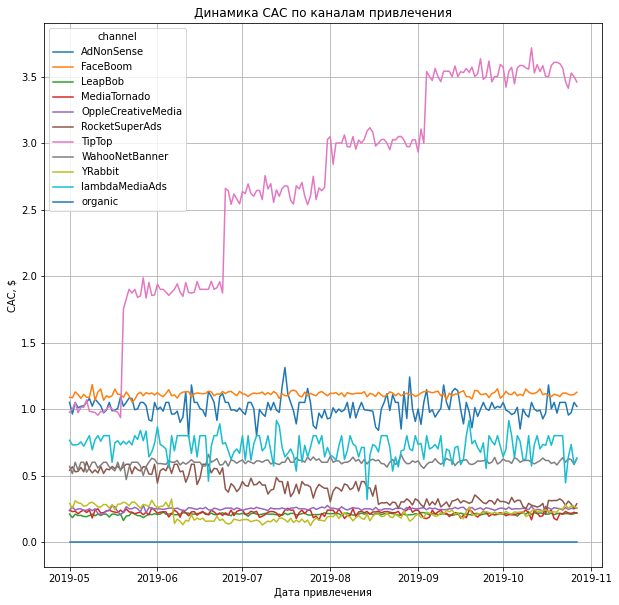

In [18]:
# строим график истории изменений CAC по каналам привлечения
profiles.pivot_table(
   index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(10, 10))
# называем наш график
plt.title('Динамика САС по каналам привлечения')
# называем оси графика
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
print("Общая сумма расходов на маркетинг - ",profiles['acquisition_cost'].sum())
plt.show()

**ВЫВОДЫ**

САС канала `Tip Top` начиная с середины июня 2019 года непрерывно растет и на момент октября стоимость за одного посетителя составляет 3.5 доллара, в то время как у других каналах стоимость ненамного превышает 1 доллар. 
При этом `Tip Top`, как вы выяснили ранее приносит нам лишь 9% платных посетителей.

Лидером  по привлечению покупателей является:  
* `FaceBoom`(1.1 доллар);
* `AdNonSense`(1 доллар);
* `lambdaMediaAds`(0.7 доллара).

Таким образом, возможно, верным решением будет прекратитть закупку трафика по каналу `Tip Top`.

<a id="payback"></a>
# Выявление окупаемости рекламы для привлечения пользователей

Окупаемость рекламы мы будем определять по таким показателям как LTV и ROI. Сначала посмотрим на общую картину окупаемости, затем посмотрим на окупаемость с разбивкой по устройствам, странам и по рекламным каналам.

<a id="common_payback"></a>
## Анализ общей окупаемости рекламы 

Установим момент и горизонт анализа данных. Мы изучаем данные с  1 ноября 2019 года, и зададим двухнедельный горизонт анализа. 

In [19]:
# устанавливаем момент анализа
observation_date = datetime(2019, 11, 1).date()  
# устанавливаем горизонт анализа 
horizon_days = 14  

Так же следует убрать из нашего исследования всех органически пришедших пользователей, поскольку отдел маркетинга не тратит бюджет компании на этих пользователей, а доход они приносят.

Следовательно, чтоб получить наиболее достоверную информацию и понять, где находится проблема, следует убрать органически пришедших пользователей, тем более, как мы выяснили ранее, они составляют 38% наших посетителей.

In [20]:
# использует метод query(), чтоб отфильтровать данные по каналам привлечения
profiles = profiles.query('channel != "organic"')

Теперь изучим LTV и ROI на отфильтрованных данных.

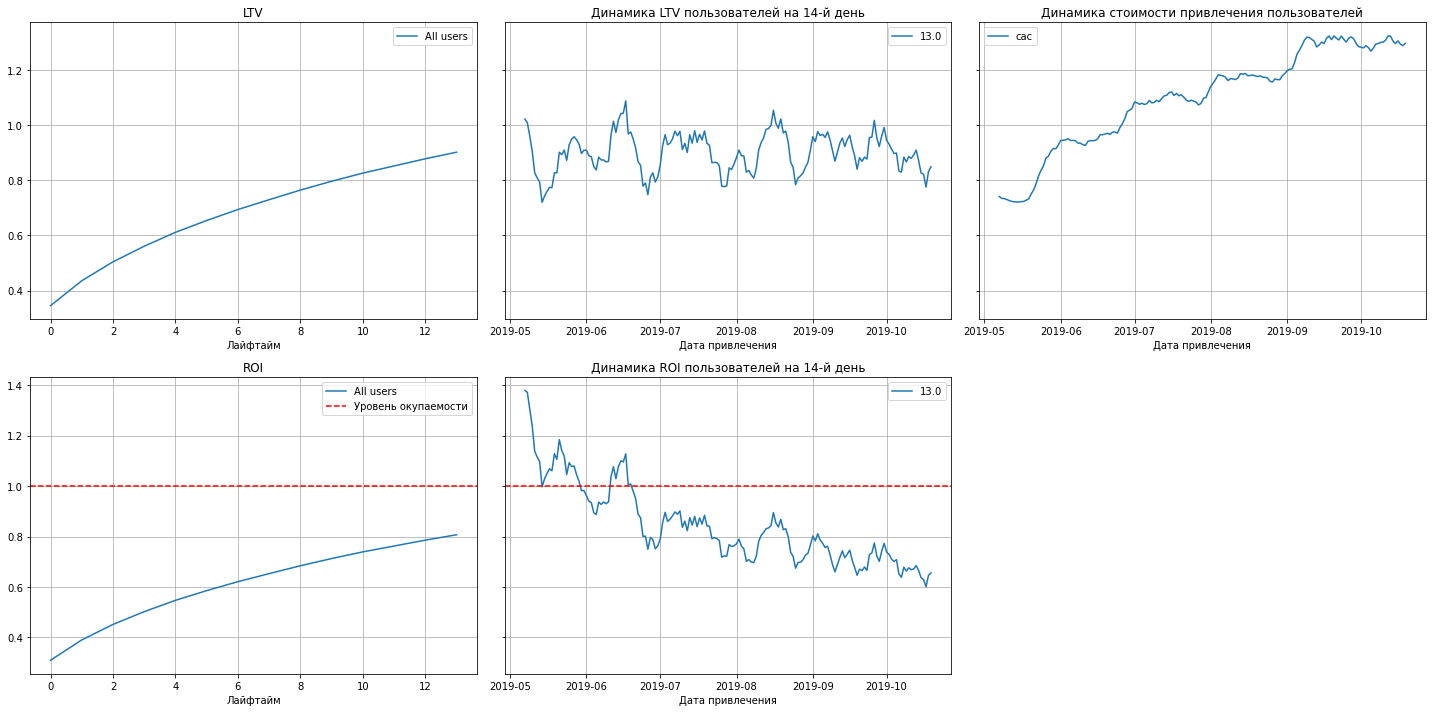

In [21]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)
# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Из графиков мы видим: 
 * LTV стабилен, поэтому можно сделать вывод, что проблема не в покупателях;
 * CAC начиная с середины мая скачкообразно растет, следовательно  есть проблема в увеличении рекламного бюджета;
 * реклама не окупается. Окупаемость инвестиций постепенно падала и в середине июля 2019 года, ROI опустился ниже уровня окупаемости.
    
Не смотря на рост CAC, ROI продолжает падать. Не удивительно, что компания терпит убытки. Для дальнейшего исследования изучим окупаемость рекламы с разбивкой по устройствам, странам и рекламным каналам и найдем источник финансовых проблем компании.


<a id="devices_payback"></a>
## Анализ окупаемости рекламы с разбивкой по устройствам 

Изучим окупаемость рекламы с разбивкой по устройствам.

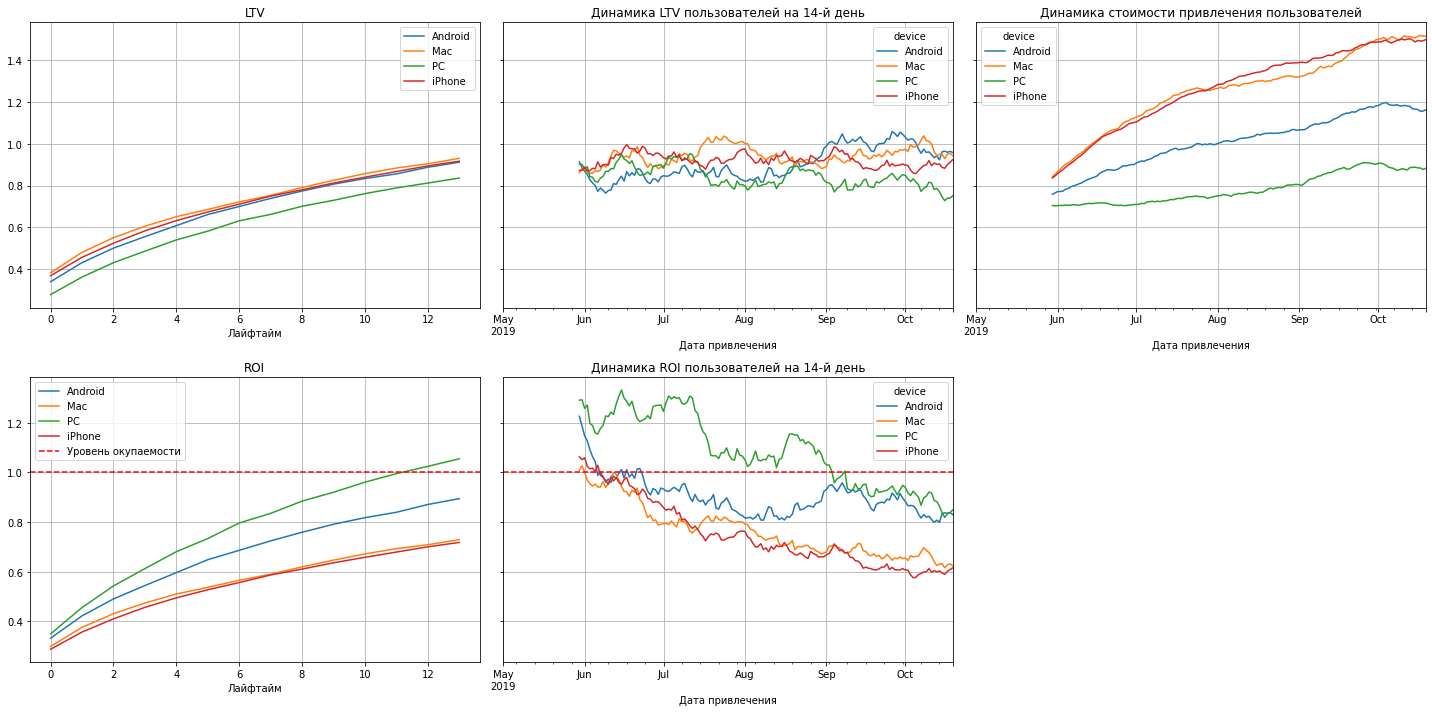

In [22]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=30
)

Из графиков мы видим:
 * ROI все также падает, CAC растет;
 * у пользователей, пользующихся приложением с PC, ROI падает не так быстро, как у пользователей с других устройств и пока окупается;
 * у пользоватеей с Android начиная с середина августа 2019 начинает постепенно расти ROI, чего не скажешь об остальных устройствах. И не смотря на то, что ROI все еще ниже уровня окупаемости, потенциал есть и нужно в дальнейшем следить за этим показателем;
 * пользователи MAC и iPhone, несмотря на наибольшую стоимость привлечения клиентов и лучшую конверсию на рынке, не окупаются совсем.

<a id="country_payback"></a>
## Анализ окупаемости рекламы с разбивкой по странам 

Теперь изучим окупаемость рекламы с разбивкой по странам.

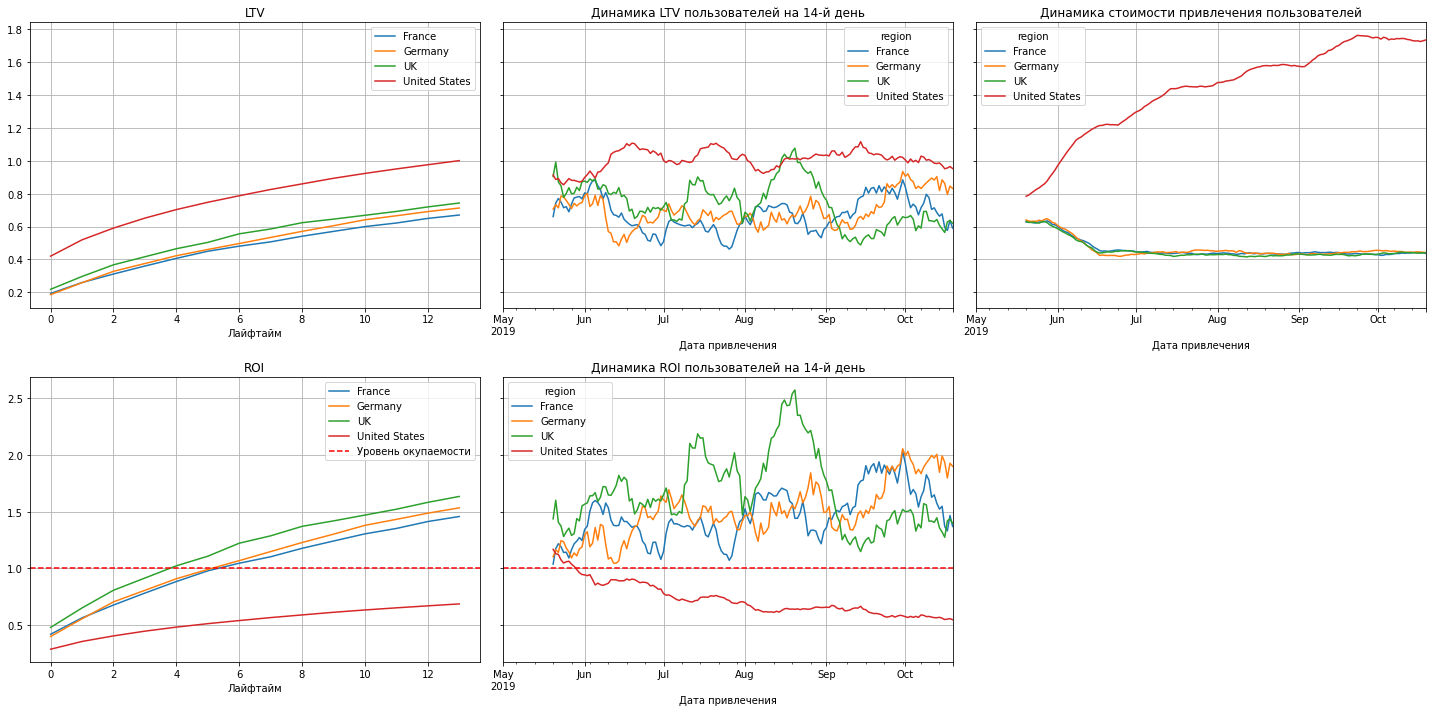

In [23]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=20
) 

Из графиков мы видим:
 * **рост CAC и падание ROI происходит из-за пользователи из США**. Не смотря на то, что они приносят наибольшую выгоду, на них тратится в разы больше инвестиций, в результате чего - не окупаемость;
 
 
 * у пользователей из других страт CAC стабилен и даже падает (от 0.4 доллар до 0.3 доллара в среднем), в то время как у США за пол года он вырос от 0.8 доллара до 1.7 доллара за посетителя;
 
 
 * ROI у США ниже уровня окупаемости и падает. Окупаемость составляет лишь 50% против 150% у остальных стран (в 3 раза меньше), что очень мало;
 
 
 * график динамики ROI нам показывает что постоянно растущий ROI наблюдается у пользователей из Германии. У остальных стран он постепенно падает (даже у Великобритании, имеющий самый большой уровень ROI на момент исследования).

<a id="channels_payback"></a>
##  Анализ окупаемости рекламы с разбивкой по рекламным каналам

Теперь изучим окупаемость рекламы с разбивкой по рекламным каналам.

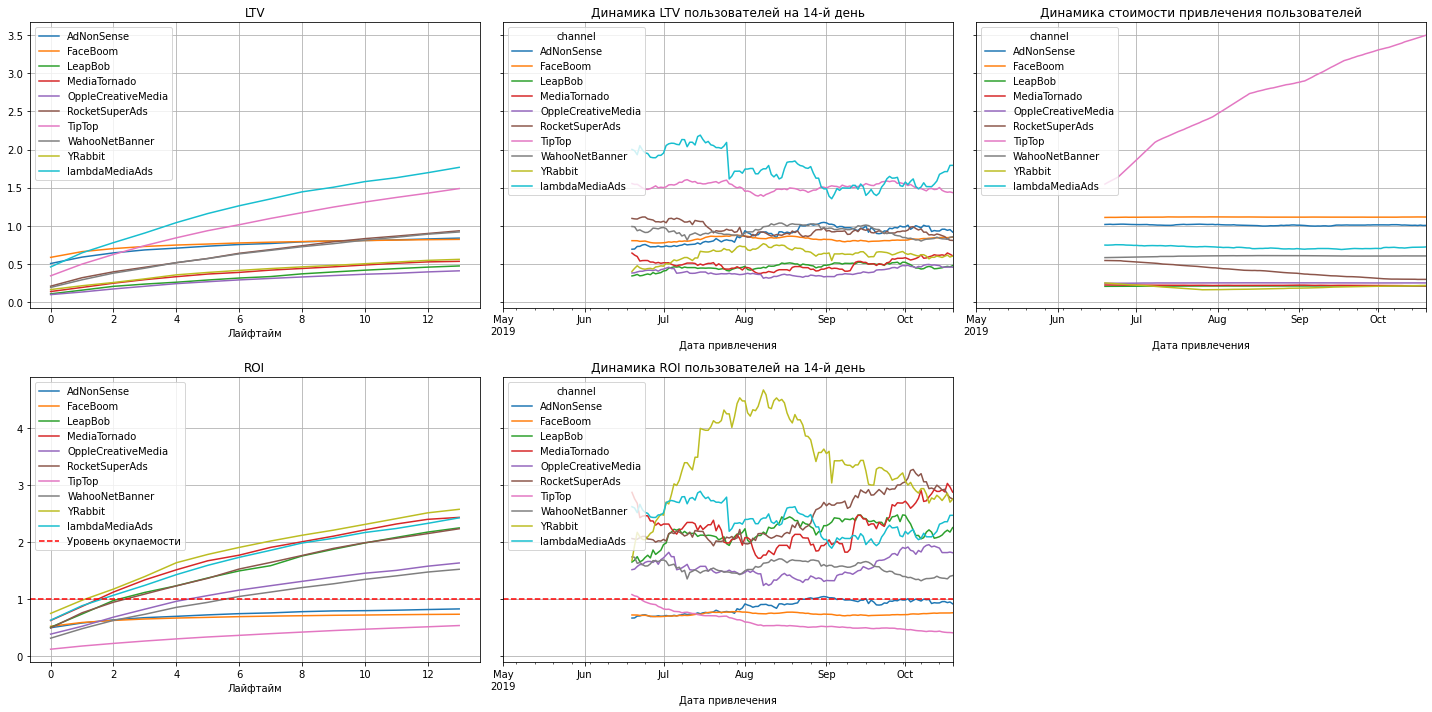

In [24]:
# смотрим окупаемость с разбивкой по источникам привлечения

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window= 50
) 

Из графиков мы видим:
 * наибольший `LTV` и у `lambdaMediaAds`; 
 * самый высокий и постоянно растущий уровень CAC у `Tip Top` (при стабильном LTV), остальные каналы привлечения стабильны, а у канала `RocketSuperAds` СAC даже падает (с 0.6 доллара до 0.25 доллара);
 * у `Tip To`p ROI ниже уровня окупаемости, и постепено падает. Так же не окупаются у нас канал `FaceBoom` и `AdNonSense`;
 * наиболее высокий и растущий ROI у нас показывает `MediaTornado` и `RocketSuperAds`. Лидер по `lambdaMediaAds` также показывает неплохие показатели.

Подозрителен такой рост CAC и у США и канала TipTop. Посмотрим, возможно этот канал направлен на американского пользователя? Сделаем срез данных по данному каналу и сохраним их в переменную `tiptop`. Затем найдем по регионам относительную частоту уникальных значений.

In [25]:
# делаем срез даннных
tiptop = profiles.query('channel == "TipTop"')
# фильтруем данные по региону
tiptop['region'].value_counts(normalize=True).to_frame()

,region
United States,1.00


Теперь понятно, почему у США такие плохие показатели. С `TipTop` мы должны срочно перестать работать!

<a id="payback_problems"></a>
## Чем могут быть вызваны проблемы окупаемости? 

Для того, чтоб определить чем могут быть вызваны проблемы окупаемости изучим конверсию и удержания с разбивкой по странам, рекламным каналам и по устройствам.

<a id="conversion_retention_country"></a>
###  Анализ  конверсии и удержания с разбивкой по странам 

Изучим конверсию и удержание с разбивкой по странам.

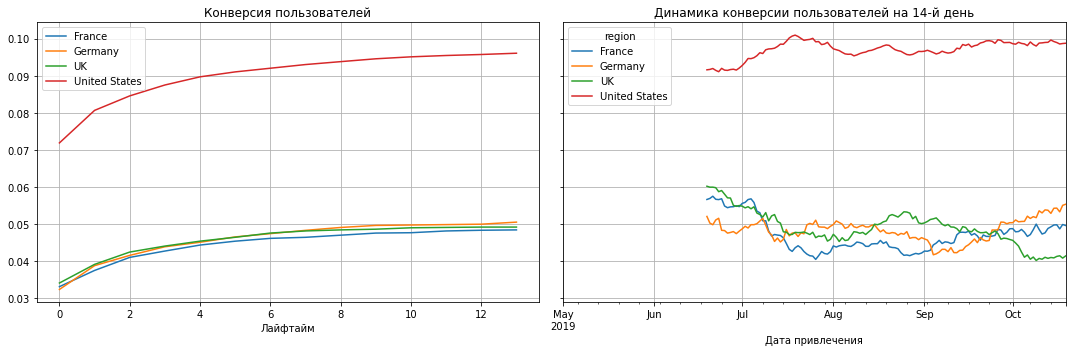

In [26]:
# смотрим конверсию с разбивкой по странам
dimensions = ['region']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days,  window= 50) 

Из графиков мы видим:
    
 * лучше всего конвертируются пользователи из Штатов;
 * показатель CR в Великобритании постепенно падает;
 * конверсия в Германии и Франции идет очень хорошо и постоянно.

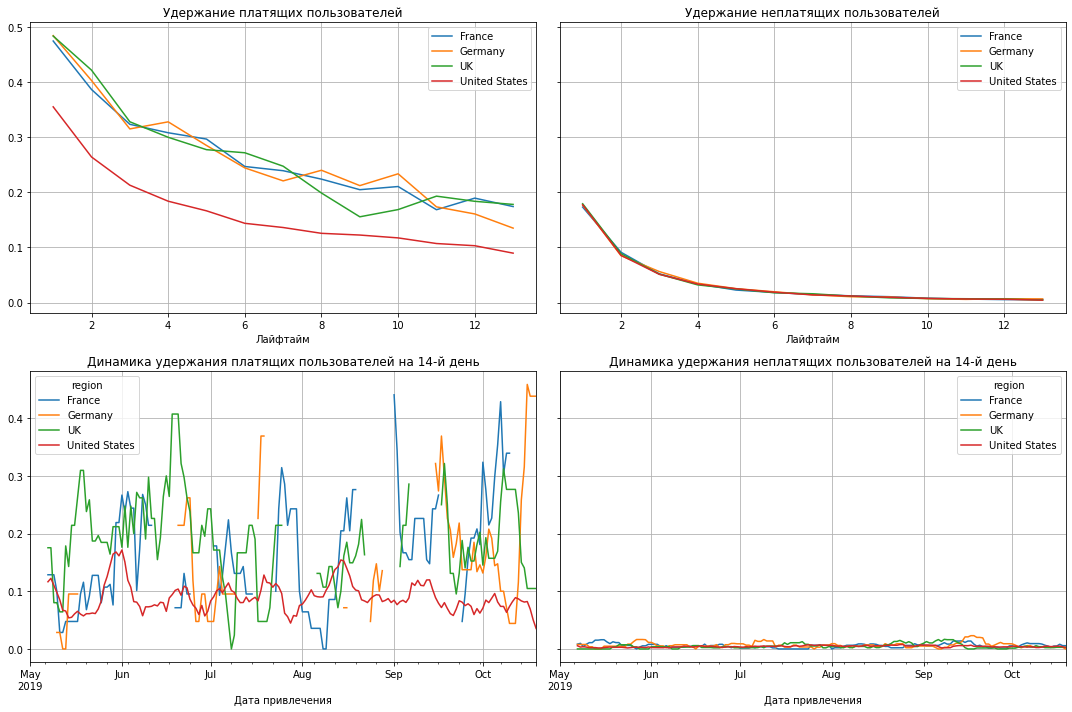

In [27]:
# смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Из графиков мы видим:


Действительно, пользователи из США стабильно плохо удерживаются.
На динамике удержания платящих пользователей видно, что показатель не поднимается выше 0.15, а к концу двух недель упал до 0.5.

У пользователей из других стран показатели же в некоторые месяца достигают  показателей 0.4 и 0.5.

<a id="conversion_retention_channels"></a>
###  Анализ  конверсии и удержания с разбивкой по рекламным каналам 

Изучим конверсию и удержание с разбивкой по рекламным каналам.

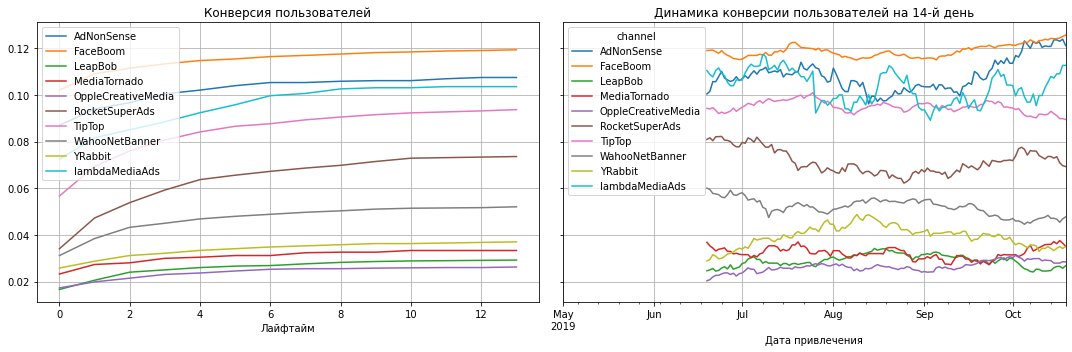

In [28]:
# смотрим конверсию с разбивкой по рекламным каналам
dimensions = ['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days,  window= 50) 

С конверсией все хорошо. Посмотрим, что нам покажет удержание.

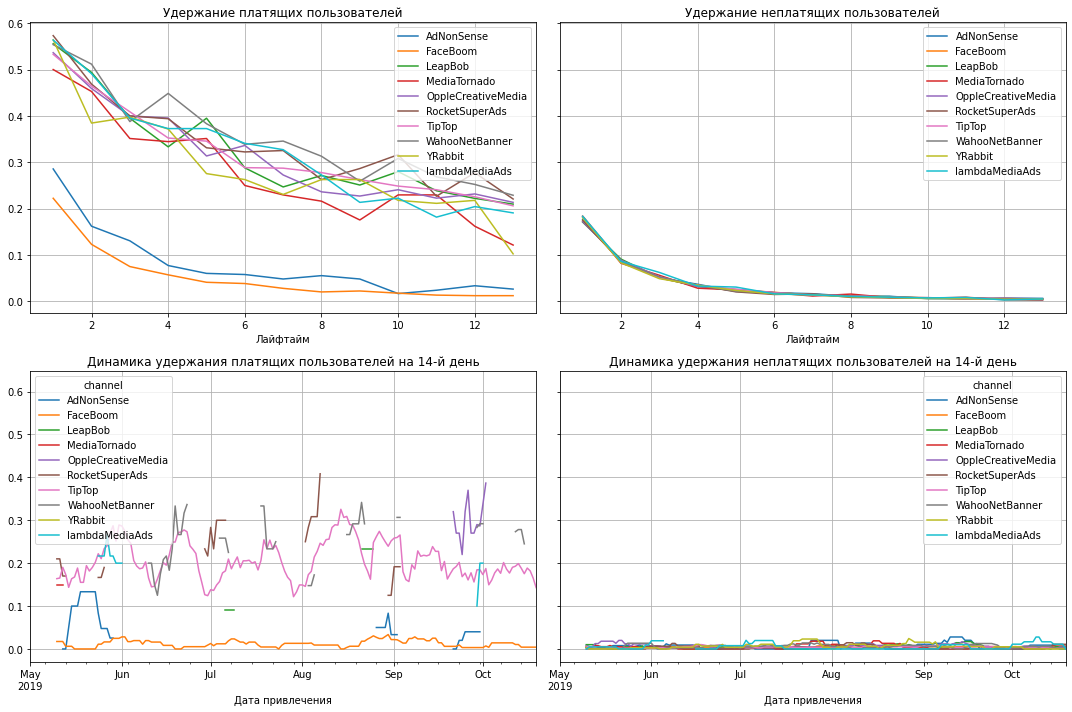

In [29]:
# смотрим удержание с разбивкой по каналам привлечения

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days, window= 10) 

Как видно из графиков, динамика удержание у `FaceBoom` и `AdNonSense` самая низкая на 14 день, причем стабильно низкая около нуля.

<a id="conversion_retention_devices"></a>
###  Анализ  конверсии и удержания с разбивкой по устройствам

Изучим конверсию и удержание с разбивкой по устройствам.

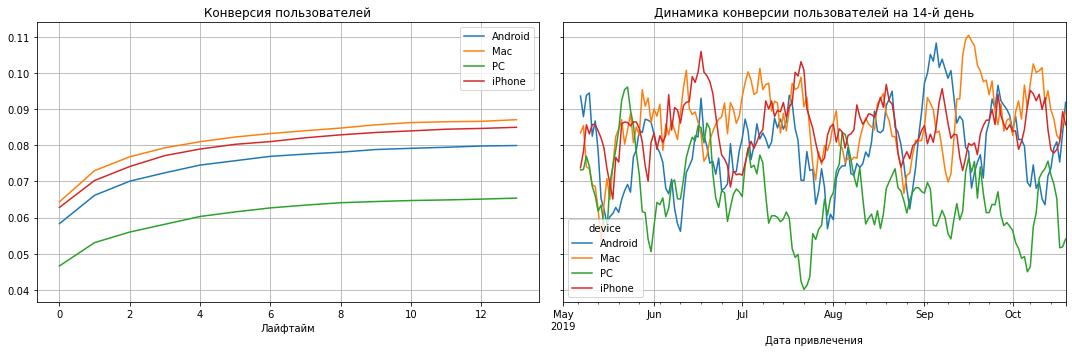

In [30]:
# смотрим конверсию с разбивкой по устройствам
dimensions = ['device']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

График показывает нам, что наиболее низкая конверсия у PC, не смотря на то, что реклама как раз на нем окупается, как мы узнали ранее. Взглянем на удержание.

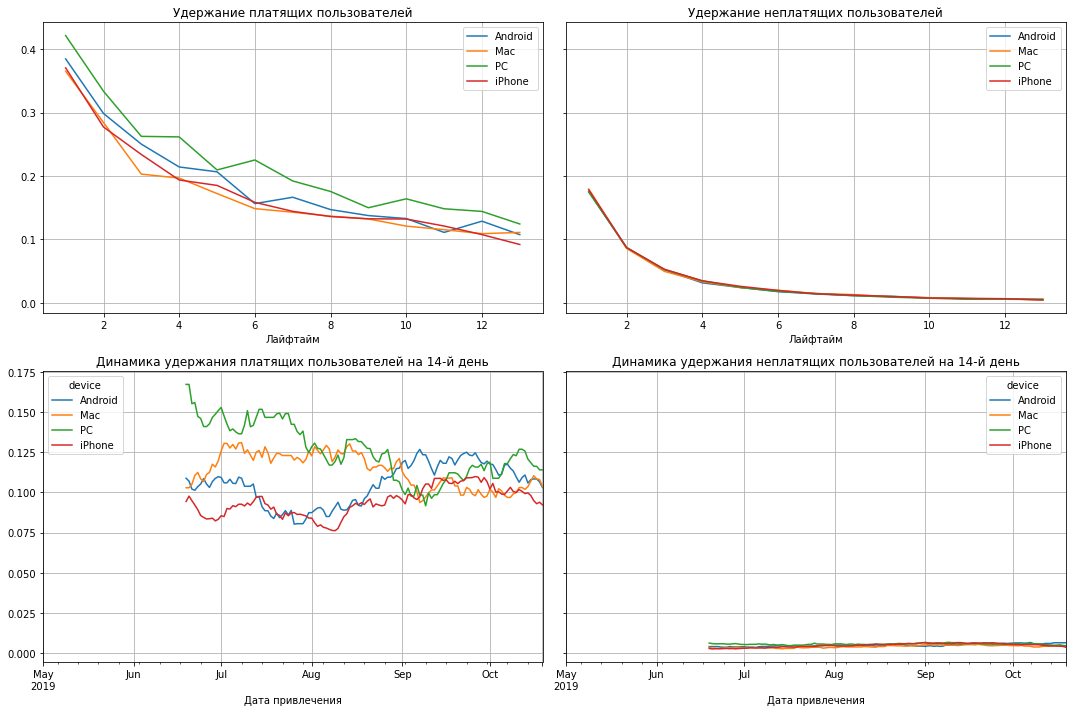

In [31]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days, window= 50) 

С удержанием все в порядке.

**ВЫВОДЫ**

**Каналы привлечения**

 * не смотря на то, что,как мы узнали ранее, `FaceBoom` и `AdNonSense` приносят нам по 19% и 13% платных пользователей, они совершенно не окупается;
 

 * **от канала `TipTop` мы вынуждены будем отказаться, поскольку именно из-за него идет рост CAC и падание ROI у пользователй из США**;
 
 
 * на третем на четвертом месте по платным пользователем у нас находится `lambdaMediaAds`(10%) и  `RocketSuperAds`(7%). Первый показывает нам лучший LTV , стабильно растущий ROI  и стабильный рост CAC. Канал `RocketSuperAds` показывает неплохой LTV, снижающийся CAC(0.25$) и растущий ROI;
 
 
 * **отделу маркетинга определено нужно взять эти два рекламных канала на вооружение**.

**Страны**

* лучше всего конвертируются пользователи из Штатов, однако пользователи из США стабильно плохо удерживаются; 


* рост CAC и падание ROI происходит из-за пользователи из США. Не смотря на то, что они приносят наибольшую выгоду, на них тратится в разы больше инвестиций, в результате чего - не окупаемость;


* постоянно растущий ROI наблюдается у пользователей из Германии. У остальных стран он постепенно падает

**Устройства**

* наиболее всего пользователи пользуются телефоном;
*  у пользоватеей с Android начиная с середина августа 2019 начинает постепенно расти ROI, чего не скажешь об остальных устройствах. И не смотря на то, что ROI все еще ниже уровня окупаемости, потенциал есть и нужно в дальнейшем следить за этим показателем.

<a id="conclusion"></a>
# Выводы и рекомендации

**Причины неэффективности привлечения пользователей**

 * основная проблема привлечения пользователей - это не окупаемость рекламы;
 
 
 * очень дорого нам обходятся пользователи с США . У них СAC 1.7 доллара при том, что у других стран он падает и, в среднем, обходится в 0.3 доллара. Да, LTV и CR самый высокий у США, но и ROI самый низкий и останавливаться и расти не собирается. Кроме этого, США стабильно плохо удерживается и пользователи не возвращаются в наше приложение. И все это из-за канала привлечения `Tip-Top`, имеющий точно такие же показатели.

**Рекомендации для отдела маркетинга для повышения эффективности**

 * ОТКАЗ ОТ `Tip Top`!
  
  
 * обратить внимание на Германию, у которой,  в отличии от других стран, ROI только растет при хорошей конверсии;
 
 
 * 11 каналов привлечения, это очень много. Однозначно нужно отказаться от `Tip Top`. У отдела маркетинга уходит наибольшее количества финансов на этот канал(САС 3.5 доллара против 1 доллара у других каналов), при постоянной подающем ROI. Кроме этого реклама из таких каналов, как `FaceBoom` и `AdNonSense` так же неэффективна, т.к. ROI ниже уровня окупаемости и не подниматься;
 
 
 * на третьем на четвертом месте по платным пользователем у нас находится `lambdaMediaAds`(10%) и  `RocketSuperAds`(7%). Если первый показывает нам лучший LTV , стабильно растущий ROI и прост стабильный CAC, то канал `RocketSuperAds` показывает неплохой LTV, снижающийся CAC (0.25 доллара) и растущий ROI. Отделу маркетинга определено нужно взять эти два рекламных канала на вооружение; 
 
 
 * наиболее всего пользователи пользуются телефоном. ROI на всех носителях ниже уровня окупаемости, однако у пользователей Android мы видим положительную динамику, хороший уровень удержания и конверсии.